## Imports

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data_utils

import skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint
from skorch.helper import predefined_split

from sklearn.preprocessing import MinMaxScaler

import os


## Loading in dataframe

In [24]:
data_path = '../processed_data.csv'
data = pd.read_csv(data_path, index_col=0)
data['energy(kWh/hh)'] = data['energy(kWh/hh)'].astype(float) / data['houses']
display(data.head())

scaler_energy = MinMaxScaler()
scaler_temperature = MinMaxScaler()
scaler_dewpoint = MinMaxScaler()
scaler_precipType = MinMaxScaler()
scaler_humidity = MinMaxScaler()
scaler_month = MinMaxScaler()
scaler_day = MinMaxScaler()
scaler_hour = MinMaxScaler()
scaler_minute = MinMaxScaler()
scaler_day_of_week = MinMaxScaler()

data['energy(kWh/hh)'] = scaler_energy.fit_transform(data[['energy(kWh/hh)']])
data['temperature'] = scaler_temperature.fit_transform(data[['temperature']])
data['dewPoint'] = scaler_dewpoint.fit_transform(data[['dewPoint']])
data['precipType'] = scaler_precipType.fit_transform(data[['precipType']])
data['humidity'] = scaler_humidity.fit_transform(data[['humidity']])
data['month'] = scaler_month.fit_transform(data[['month']])
data['day'] = scaler_day.fit_transform(data[['day']])
data['hour'] = scaler_hour.fit_transform(data[['hour']])
data['minute'] = scaler_minute.fit_transform(data[['minute']])
data['day_of_week'] = scaler_day_of_week.fit_transform(data[['day_of_week']])

display(data.info())
display(data.head())


,timestamp,year,month,day,hour,minute,day_of_week,weekend,holiday,energy(kWh/hh),houses,visibility,temperature,dewPoint,pressure,windSpeed,precipType,humidity
index,,,,,,,,,,,,,,,,,,
0,2011-11-23 09:00:00+00:00,2011,11,23,9,0,2,0,0,0.284500,2,4.390000,4.840000,4.680000,1027.290000,1.780000,0,0.990000
1,2011-11-23 09:30:00+00:00,2011,11,23,9,30,2,0,0,0.280500,2,5.068612,5.190130,5.095420,1027.507662,1.824055,0,0.992222
2,2011-11-23 10:00:00+00:00,2011,11,23,10,0,2,0,0,0.153333,6,6.240000,5.740000,5.460000,1027.670000,1.990000,0,0.980000
3,2011-11-23 10:30:00+00:00,2011,11,23,10,30,2,0,0,0.098000,6,8.261031,6.686929,5.598355,1027.672961,2.336091,0,0.931400
4,2011-11-23 11:00:00+00:00,2011,11,23,11,0,2,0,0,0.110286,7,10.200000,7.670000,5.740000,1027.560000,2.660000,0,0.880000


<class 'pandas.core.frame.DataFrame'>
Index: 39727 entries, 0 to 39726
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       39727 non-null  object 
 1   year            39727 non-null  int64  
 2   month           39727 non-null  float64
 3   day             39727 non-null  float64
 4   hour            39727 non-null  float64
 5   minute          39727 non-null  float64
 6   day_of_week     39727 non-null  float64
 7   weekend         39727 non-null  int64  
 8   holiday         39727 non-null  int64  
 9   energy(kWh/hh)  39727 non-null  float64
 10  houses          39727 non-null  int64  
 11  visibility      39727 non-null  float64
 12  temperature     39727 non-null  float64
 13  dewPoint        39727 non-null  float64
 14  pressure        39727 non-null  float64
 15  windSpeed       39727 non-null  float64
 16  precipType      39727 non-null  float64
 17  humidity        39727 non-null  floa

None

,timestamp,year,month,day,hour,minute,day_of_week,weekend,holiday,energy(kWh/hh),houses,visibility,temperature,dewPoint,pressure,windSpeed,precipType,humidity
index,,,,,,,,,,,,,,,,,,
0,2011-11-23 09:00:00+00:00,2011,0.909091,0.733333,0.391304,0.0,0.333333,0,0,0.496932,2,4.390000,0.275064,0.490958,1027.290000,1.780000,0.0,0.979768
1,2011-11-23 09:30:00+00:00,2011,0.909091,0.733333,0.391304,1.0,0.333333,0,0,0.486617,2,5.068612,0.284254,0.504870,1027.507662,1.824055,0.0,0.982632
2,2011-11-23 10:00:00+00:00,2011,0.909091,0.733333,0.434783,0.0,0.333333,0,0,0.158681,6,6.240000,0.298686,0.517080,1027.670000,1.990000,0.0,0.966876
3,2011-11-23 10:30:00+00:00,2011,0.909091,0.733333,0.434783,1.0,0.333333,0,0,0.015988,6,8.261031,0.323540,0.521713,1027.672961,2.336091,0.0,0.904222
4,2011-11-23 11:00:00+00:00,2011,0.909091,0.733333,0.478261,0.0,0.333333,0,0,0.047670,7,10.200000,0.349342,0.526457,1027.560000,2.660000,0.0,0.837959


## Adding Input and target columns

In [25]:

data_mod = data.drop(['timestamp', 'houses', 'holiday', 'visibility', 'pressure', 'windSpeed'], axis=1)
    
day_features = [
    'month', 
    'day', 
    'hour', 
    'minute', 
    'day_of_week', 
    'weekend'
]
weather_features = [ 
    'temperature', 
    'dewPoint',
    'precipType',
    'humidity',
]

input_frame = ['energy(kWh/hh)']

timesteps = 48

input_features = []
target_features_next = []

for i in range(1, timesteps+1):
    prev_list = []
    next_list = []
    for j, feature in enumerate(input_frame):
        if i < timesteps:
            prev_list.append(feature + '_prev_' + str(i*.5))
            if feature in day_features:
                data_mod[prev_list[-1]] = data_mod[feature].shift(-i)
            else:
                data_mod[prev_list[-1]] = data_mod[feature].shift(i)
        if feature in ['energy(kWh/hh)']:
            next_list.append(feature + '_next_' + str(i*.5))
            data_mod[next_list[-1]] = data_mod[feature].shift(-i)
    input_features.insert(0, prev_list)
    target_features_next += next_list

input_features.remove([])
input_features_prev = []
for i in input_features:
    input_features_prev += i


columns = day_features + weather_features + input_features_prev + input_frame + target_features_next
print(columns)

data_mod = data_mod[columns]


['month', 'day', 'hour', 'minute', 'day_of_week', 'weekend', 'temperature', 'dewPoint', 'precipType', 'humidity', 'energy(kWh/hh)_prev_23.5', 'energy(kWh/hh)_prev_23.0', 'energy(kWh/hh)_prev_22.5', 'energy(kWh/hh)_prev_22.0', 'energy(kWh/hh)_prev_21.5', 'energy(kWh/hh)_prev_21.0', 'energy(kWh/hh)_prev_20.5', 'energy(kWh/hh)_prev_20.0', 'energy(kWh/hh)_prev_19.5', 'energy(kWh/hh)_prev_19.0', 'energy(kWh/hh)_prev_18.5', 'energy(kWh/hh)_prev_18.0', 'energy(kWh/hh)_prev_17.5', 'energy(kWh/hh)_prev_17.0', 'energy(kWh/hh)_prev_16.5', 'energy(kWh/hh)_prev_16.0', 'energy(kWh/hh)_prev_15.5', 'energy(kWh/hh)_prev_15.0', 'energy(kWh/hh)_prev_14.5', 'energy(kWh/hh)_prev_14.0', 'energy(kWh/hh)_prev_13.5', 'energy(kWh/hh)_prev_13.0', 'energy(kWh/hh)_prev_12.5', 'energy(kWh/hh)_prev_12.0', 'energy(kWh/hh)_prev_11.5', 'energy(kWh/hh)_prev_11.0', 'energy(kWh/hh)_prev_10.5', 'energy(kWh/hh)_prev_10.0', 'energy(kWh/hh)_prev_9.5', 'energy(kWh/hh)_prev_9.0', 'energy(kWh/hh)_prev_8.5', 'energy(kWh/hh)_prev_

/tmp/ipykernel_480605/3169163658.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_mod[prev_list[-1]] = data_mod[feature].shift(i)
/tmp/ipykernel_480605/3169163658.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_mod[next_list[-1]] = data_mod[feature].shift(-i)
/tmp/ipykernel_480605/3169163658.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

## Removing Datapoints without previous or next info

In [26]:
# Removing NaN value rows
data_mod_clean = data_mod[data_mod[input_features_prev[0]].notna()]
data_mod_clean = data_mod_clean[data_mod_clean[target_features_next[-1]].notna()]
data_mod_clean = data_mod_clean.reset_index(drop=True)

data_mod_clean.to_csv('../processed_data_train.csv', index=False)

display(data_mod_clean.head())
display(data_mod_clean.tail())

,month,day,hour,minute,day_of_week,weekend,temperature,dewPoint,precipType,humidity,...,energy(kWh/hh)_next_19.5,energy(kWh/hh)_next_20.0,energy(kWh/hh)_next_20.5,energy(kWh/hh)_next_21.0,energy(kWh/hh)_next_21.5,energy(kWh/hh)_next_22.0,energy(kWh/hh)_next_22.5,energy(kWh/hh)_next_23.0,energy(kWh/hh)_next_23.5,energy(kWh/hh)_next_24.0
0,0.909091,0.766667,0.347826,1.0,0.5,0,0.403604,0.636611,0.0,0.932091,...,0.221053,0.171747,0.125122,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973
1,0.909091,0.766667,0.391304,0.0,0.5,0,0.413646,0.649364,0.0,0.928201,...,0.171747,0.125122,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080
2,0.909091,0.766667,0.391304,1.0,0.5,0,0.423851,0.658672,0.0,0.919176,...,0.125122,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080,0.204140
3,0.909091,0.766667,0.434783,0.0,0.5,0,0.436481,0.666778,0.0,0.902418,...,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080,0.204140,0.239292
4,0.909091,0.766667,0.434783,1.0,0.5,0,0.453797,0.675922,0.0,0.875329,...,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080,0.204140,0.239292,0.165834


,month,day,hour,minute,day_of_week,weekend,temperature,dewPoint,precipType,humidity,...,energy(kWh/hh)_next_19.5,energy(kWh/hh)_next_20.0,energy(kWh/hh)_next_20.5,energy(kWh/hh)_next_21.0,energy(kWh/hh)_next_21.5,energy(kWh/hh)_next_22.0,energy(kWh/hh)_next_22.5,energy(kWh/hh)_next_23.0,energy(kWh/hh)_next_23.5,energy(kWh/hh)_next_24.0
39627,0.090909,0.833333,0.956522,0.0,0.333333,0,0.311810,0.438379,0.0,0.734826,...,0.452177,0.551650,0.667100,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284
39628,0.090909,0.833333,0.956522,1.0,0.333333,0,0.312320,0.440083,0.0,0.742299,...,0.551650,0.667100,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642
39629,0.090909,0.833333,1.000000,0.0,0.333333,0,0.312597,0.440388,0.0,0.747717,...,0.667100,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642,0.413828
39630,0.090909,0.833333,1.000000,1.0,0.333333,0,0.308508,0.441337,0.0,0.756796,...,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642,0.413828,0.318439
39631,0.090909,0.866667,0.000000,0.0,0.500000,0,0.305773,0.442733,0.0,0.760609,...,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642,0.413828,0.318439,0.302225


In [27]:
input_names = input_features_prev + input_frame + weather_features + day_features
print(input_names)
target_names = target_features_next
print(target_names)

['energy(kWh/hh)_prev_23.5', 'energy(kWh/hh)_prev_23.0', 'energy(kWh/hh)_prev_22.5', 'energy(kWh/hh)_prev_22.0', 'energy(kWh/hh)_prev_21.5', 'energy(kWh/hh)_prev_21.0', 'energy(kWh/hh)_prev_20.5', 'energy(kWh/hh)_prev_20.0', 'energy(kWh/hh)_prev_19.5', 'energy(kWh/hh)_prev_19.0', 'energy(kWh/hh)_prev_18.5', 'energy(kWh/hh)_prev_18.0', 'energy(kWh/hh)_prev_17.5', 'energy(kWh/hh)_prev_17.0', 'energy(kWh/hh)_prev_16.5', 'energy(kWh/hh)_prev_16.0', 'energy(kWh/hh)_prev_15.5', 'energy(kWh/hh)_prev_15.0', 'energy(kWh/hh)_prev_14.5', 'energy(kWh/hh)_prev_14.0', 'energy(kWh/hh)_prev_13.5', 'energy(kWh/hh)_prev_13.0', 'energy(kWh/hh)_prev_12.5', 'energy(kWh/hh)_prev_12.0', 'energy(kWh/hh)_prev_11.5', 'energy(kWh/hh)_prev_11.0', 'energy(kWh/hh)_prev_10.5', 'energy(kWh/hh)_prev_10.0', 'energy(kWh/hh)_prev_9.5', 'energy(kWh/hh)_prev_9.0', 'energy(kWh/hh)_prev_8.5', 'energy(kWh/hh)_prev_8.0', 'energy(kWh/hh)_prev_7.5', 'energy(kWh/hh)_prev_7.0', 'energy(kWh/hh)_prev_6.5', 'energy(kWh/hh)_prev_6.0',

## Simple Feed Forward Network

In [28]:
class ForecastNetwork(nn.Module):
    def __init__(self, input_time_dim, input_other_dim, output_dim, layers, nodes, activation=nn.ReLU):
        super(ForecastNetwork, self).__init__()
        self.input_time_dim = input_time_dim
        self.input_other_dim = input_other_dim
        self.output_dim = output_dim
        self.layers = layers
        self.nodes = nodes
        self.conv_channels = 4
        self.kernel_size = 8

        self.conv_dim = int((input_time_dim - 1*(self.kernel_size-1) -1)/1 + 1)

        layers = []

        # Time convolution
        self.unflat = nn.Unflatten(1, (1, self.input_time_dim))
        self.conv1 = nn.Conv1d(1, self.conv_channels, self.kernel_size, bias=False)
        self.flat = nn.Flatten()

        for i in range(self.layers):
            if i == 0:
                layers.append(nn.Linear(self.input_other_dim + self.conv_dim*self.conv_channels, self.nodes))
                layers.append(activation())
            elif i == self.layers - 1:
                layers.append(nn.Linear(self.nodes, self.output_dim))
            else:
                layers.append(nn.Linear(self.nodes, self.nodes))
                layers.append(activation())

        self.module = nn.Sequential(*layers)

    
    def forward(self, x):
        conv = self.unflat(x[:, self.input_other_dim:])
        conv = self.conv1(conv)
        conv = self.flat(conv)
        conv = torch.cat((conv, x[:, :self.input_other_dim]), dim=1)
        out = self.module(conv)
        return out


## Making datasets

In [29]:

input_names_energy = [x for x in input_names if 'energy' in x]

target_names_energy = [x for x in target_names if 'energy' in x]

print(input_names_energy)
print(target_names)

data_mod_clean = pd.read_csv('../processed_data_train.csv')

inputs_energy = data_mod_clean[day_features + weather_features + input_names_energy]
targets = data_mod_clean[target_names_energy]

input_tensor_energy = torch.tensor(inputs_energy.values).float()
target_tensor_energy = torch.tensor(targets.values).float()

train_cut = int(len(input_tensor_energy) * 0.7)
valid_cut = int(len(input_tensor_energy) * 0.8)

dataset_train = data_utils.TensorDataset(input_tensor_energy[:train_cut], target_tensor_energy[:train_cut])
dataset_valid = data_utils.TensorDataset(input_tensor_energy[train_cut:valid_cut], target_tensor_energy[train_cut:valid_cut])
dataset_test = data_utils.TensorDataset(input_tensor_energy[valid_cut:], target_tensor_energy[valid_cut:])


['energy(kWh/hh)_prev_23.5', 'energy(kWh/hh)_prev_23.0', 'energy(kWh/hh)_prev_22.5', 'energy(kWh/hh)_prev_22.0', 'energy(kWh/hh)_prev_21.5', 'energy(kWh/hh)_prev_21.0', 'energy(kWh/hh)_prev_20.5', 'energy(kWh/hh)_prev_20.0', 'energy(kWh/hh)_prev_19.5', 'energy(kWh/hh)_prev_19.0', 'energy(kWh/hh)_prev_18.5', 'energy(kWh/hh)_prev_18.0', 'energy(kWh/hh)_prev_17.5', 'energy(kWh/hh)_prev_17.0', 'energy(kWh/hh)_prev_16.5', 'energy(kWh/hh)_prev_16.0', 'energy(kWh/hh)_prev_15.5', 'energy(kWh/hh)_prev_15.0', 'energy(kWh/hh)_prev_14.5', 'energy(kWh/hh)_prev_14.0', 'energy(kWh/hh)_prev_13.5', 'energy(kWh/hh)_prev_13.0', 'energy(kWh/hh)_prev_12.5', 'energy(kWh/hh)_prev_12.0', 'energy(kWh/hh)_prev_11.5', 'energy(kWh/hh)_prev_11.0', 'energy(kWh/hh)_prev_10.5', 'energy(kWh/hh)_prev_10.0', 'energy(kWh/hh)_prev_9.5', 'energy(kWh/hh)_prev_9.0', 'energy(kWh/hh)_prev_8.5', 'energy(kWh/hh)_prev_8.0', 'energy(kWh/hh)_prev_7.5', 'energy(kWh/hh)_prev_7.0', 'energy(kWh/hh)_prev_6.5', 'energy(kWh/hh)_prev_6.0',

## Skorch Training

In [30]:
module = ForecastNetwork(timesteps, len(day_features+weather_features), target_tensor_energy.shape[1], 6, 250)

In [32]:
cody_model_dir = '../models/cody_models'
callbacks = [
    Checkpoint(monitor='valid_loss_best', fn_prefix='convnet_', dirname=cody_model_dir)
]
net = NeuralNetRegressor(
    module,
    train_split=predefined_split(dataset_valid),
    max_epochs=300,
    lr=0.0001,
    batch_size=64,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.0001,
    criterion=nn.L1Loss,
    device='cuda',
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True,
    iterator_train__shuffle=False,
    iterator_valid__num_workers=4,
    iterator_valid__pin_memory=True,
    callbacks=callbacks
)

net = net.fit(dataset_train, y=None)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0430        0.0224     +  0.8757
      2        0.0439        0.0223     +  0.8530
      3        0.0441        0.0223        0.8206
      4        0.0445        0.0225        0.8524
      5        0.0449        0.0229        0.8718
      6        0.0453        0.0235        0.8422
      7        0.0454        0.0238        0.8355
      8        0.0454        0.0237        0.8505
      9        0.0451        0.0236        0.8593
     10        0.0449        0.0237        0.8378
     11        0.0447        0.0239        0.8195
     12        0.0445        0.0241        0.8316
     13        0.0441        0.0239        0.8048
     14        0.0438        0.0240        0.8493
     15        0.0434        0.0238        0.8200
     16        0.0431        0.0237        0.8185
     17        0.0427        0.0238        0.8165
     18        0.0422        0.0236        0.8158


## Testing Training

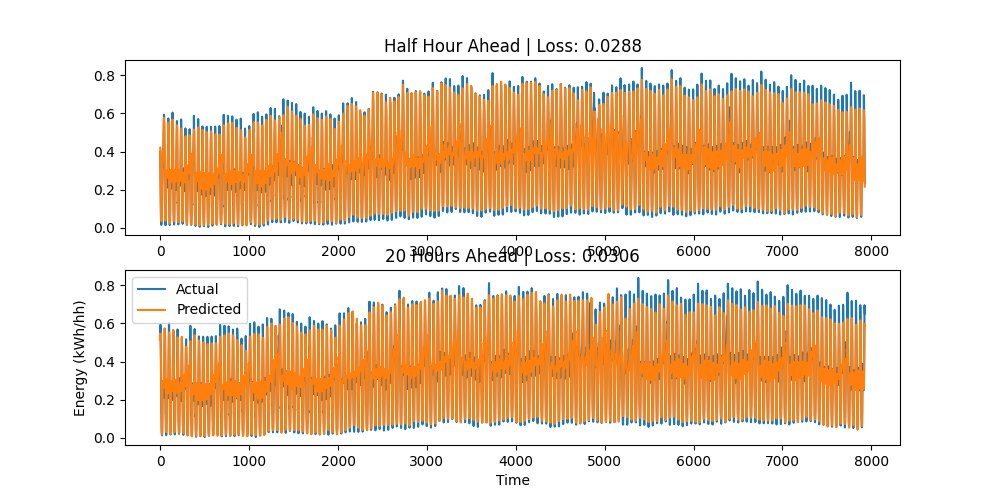

In [33]:
loss = nn.L1Loss()
x_test = dataset_test[:][0]
y_test = dataset_test[:][1]

y_pred = net.module(x_test.float().cuda()).cpu().detach()

half_pred = y_pred[:, 0]

half_loss = loss(y_pred[:, 0], y_test[:, 0]).item()
hour_loss = loss(y_pred[:, 1], y_test[:, 1]).item()
hour_half_loss = loss(y_pred[:, 2], y_test[:, 2]).item()
hour_20_loss = loss(y_pred[:, 40], y_test[:, 40])

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(y_test[:, 0], label='Actual')
ax[0].plot(y_pred[:, 0], label='Predicted')
ax[0].set_title(f'Half Hour Ahead | Loss: {half_loss:.4f}')

#ax[1].plot(y_test[:, 1], label='Actual')
#ax[1].plot(y_pred[:, 1], label='Predicted')
#ax[1].set_title(f'Hour Ahead | Loss: {hour_loss:.4f}')

#ax[2].plot(y_test[:, 2], label='Actual')
#ax[2].plot(y_pred[:, 2], label='Predicted')
#ax[2].set_title(f'Hour and Half Ahead | Loss: {hour_half_loss:.4f}')

ax[1].plot(y_test[:, 40], label='Actual')
ax[1].plot(y_pred[:, 40], label='Predicted')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy (kWh/hh)')
ax[1].set_title(f'20 Hours Ahead | Loss: {hour_20_loss:.4f}')

plt.legend()
plt.show()

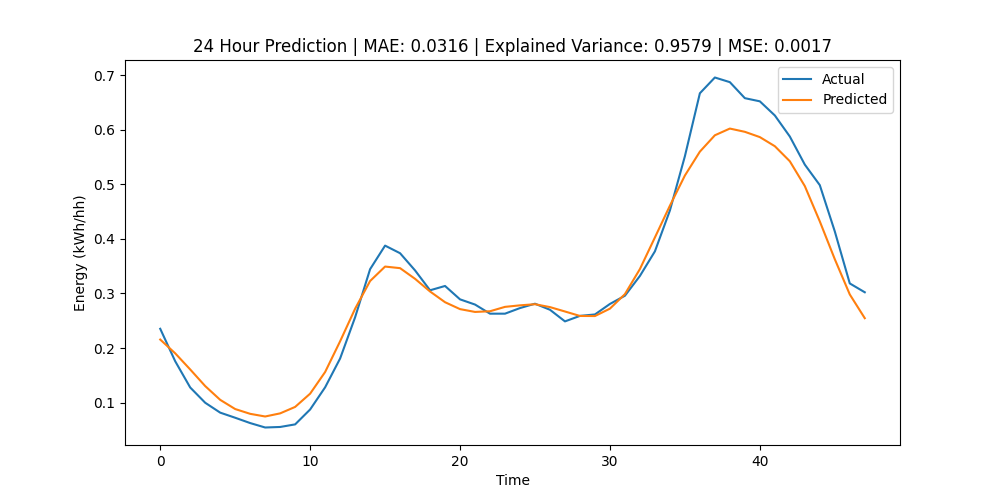

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
y_pred = y_pred.detach().numpy()
y_test = y_test.detach().numpy()
accuracy = mean_absolute_error(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)
mean_squared = mean_squared_error(y_test, y_pred)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(y_test[-1], label='Actual')
ax.plot(y_pred[-1], label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Energy (kWh/hh)')
ax.set_title(f'24 Hour Prediction | MAE: {accuracy:.4f} | Explained Variance: {explained_variance:.4f} | MSE: {mean_squared:.4f}')
plt.legend()

count = np.arange(0, 24, 0.5)
output = np.concatenate((count, y_test[-2], y_pred[-2])).reshape(3, 48).T
np.savetxt('../conv_results.csv', output, delimiter=',')


In [35]:
class ForecastLSTM2_0(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, other_dim, hidden_nodes, linear_layers, device='cuda', bidirectional=False, dropout=0.1):
        super(ForecastLSTM2_0, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device
        self.seq_length = seq_length
        self.num_directions = 2 if bidirectional else 1
        self.other_dim = other_dim
        self.channels = 4
        
        self.conv_in_dim = seq_length
        self.kernel_size = 8
        self.conv_dim1 = int(((self.conv_in_dim) - 1*(self.kernel_size-1) -1)/1 + 1)
        self.conv_dim2 = int(((self.conv_dim1) - 1*(self.kernel_size-1) -1)/1 + 1)

        # Convolutional Preprocessor
        decode_conv = []
        decode_conv.append(nn.Unflatten(1, (1, self.conv_in_dim)))
        decode_conv.append(nn.Conv1d(1, self.channels, self.kernel_size, bias=False))
        decode_conv.append(nn.ReLU())
        decode_conv.append(nn.Flatten())

        self.decode_conv = nn.Sequential(*decode_conv)

        preprocess_decode = []
        preprocess_decode.append(nn.Dropout(dropout))
        preprocess_decode.append(nn.Linear(self.conv_dim1*self.channels + self.other_dim, self.input_size*(self.seq_length)))
        preprocess_decode.append(nn.ReLU())
        preprocess_decode.append(nn.Dropout(dropout))
        #preprocess_decode.append(nn.Linear(self.input_size*(self.seq_length//2), self.input_size*self.seq_length))
        #preprocess_decode.append(nn.ReLU())

        self.decode = nn.Sequential(*preprocess_decode) 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout/2)

        layers = []        

        for i in range(linear_layers-1):
            if i == 0:
                layers.append(nn.Linear(hidden_size*self.num_directions, hidden_nodes))
            else:
                layers.append(nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_nodes, num_classes))

        self.linear = nn.Sequential(*layers)

    def forward(self, x):
        x_preprocess = self.decode_conv(x[:, self.other_dim:])
        x_preprocess = torch.cat((x_preprocess, x[:, :self.other_dim]), dim=1)
        x_preprocess = self.decode(x_preprocess)
        x_preprocess = x_preprocess.reshape(x.shape[0], self.seq_length, self.input_size)

        h_0 = Variable(torch.zeros(
            self.num_layers*self.num_directions, x.size(0), self.hidden_size)).to(self.device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers*self.num_directions, x.size(0), self.hidden_size)).to(self.device)

        h_all, (h_out, c_out) = self.lstm(x_preprocess, (h_0, c_0))

        out = self.linear(h_all).squeeze(-1)
        
        return out

In [36]:
data_mod_clean = pd.read_csv('../processed_data_train.csv')

inputs = data_mod_clean[input_names]
targets = data_mod_clean[target_names]

input_tensor = torch.tensor(inputs.values).float()
target_tensor = torch.tensor(targets.values).float().reshape(-1, timesteps)

dataset_train = data_utils.TensorDataset(input_tensor[:int(len(input_tensor) * 0.7)], target_tensor[:int(len(target_tensor) * 0.7)])
dataset_valid = data_utils.TensorDataset(input_tensor[int(len(input_tensor) * 0.7):int(len(input_tensor) * 0.8)], target_tensor[int(len(target_tensor) * 0.7):int(len(target_tensor) * 0.8)])
dataset_test = data_utils.TensorDataset(input_tensor[int(len(input_tensor) * 0.8):], target_tensor[int(len(target_tensor) * 0.8):])


In [51]:
module = ForecastLSTM2_0(1, 100, 75, 3, timesteps, len(weather_features) + len(day_features), 200, 3, dropout=0.05).to('cuda')

test = module(input_tensor[0].unsqueeze(0).cuda())

In [65]:
cody_model_dir = '../models/cody_models'
callbacks = [
    Checkpoint(monitor='valid_loss_best', fn_prefix='lstm_', dirname=cody_model_dir)
]
net = NeuralNetRegressor(
    module,
    max_epochs=400,
    lr=0.0001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.00001,
    criterion=nn.L1Loss,
    device='cuda',
    train_split=predefined_split(dataset_valid),
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True,
    iterator_train__shuffle=False,
    iterator_valid__num_workers=4,
    iterator_valid__pin_memory=True,
    callbacks=callbacks
)

net = net.fit(dataset_train, y=None)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0247        0.0157     +  1.3337
      2        0.0247        0.0161        1.3139
      3        0.0247        0.0167        1.3210
      4        0.0248        0.0160        1.3344
      5        0.0249        0.0161        1.3226
      6        0.0249        0.0161        1.3081
      7        0.0248        0.0163        1.3224
      8        0.0248        0.0161        1.3324
      9        0.0249        0.0161        1.3171
     10        0.0249        0.0163        1.3136
     11        0.0248        0.0163        1.3257
     12        0.0248        0.0161        1.3170
     13        0.0248        0.0164        1.3285
     14        0.0247        0.0164        1.3418
     15        0.0248        0.0161        1.3343
     16        0.0247        0.0163        1.3324
     17        0.0248        0.0160        1.3565
     18        0.0248        0.0161        1.3189


In [62]:
net_load = NeuralNetRegressor(
    module,
    max_epochs=400,
    lr=0.0001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.000001,
    criterion=nn.L1Loss,
    device='cuda',
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True,
    iterator_train__shuffle=False,
    iterator_valid__num_workers=4,
    iterator_valid__pin_memory=True
)


net_load.initialize()
net_load.load_params(f_params=os.path.join(cody_model_dir, 'lstm_params.pt'),
                f_optimizer=os.path.join(cody_model_dir, 'lstm_optimizer.pt'),
                f_history=os.path.join(cody_model_dir, 'lstm_history.json')
)

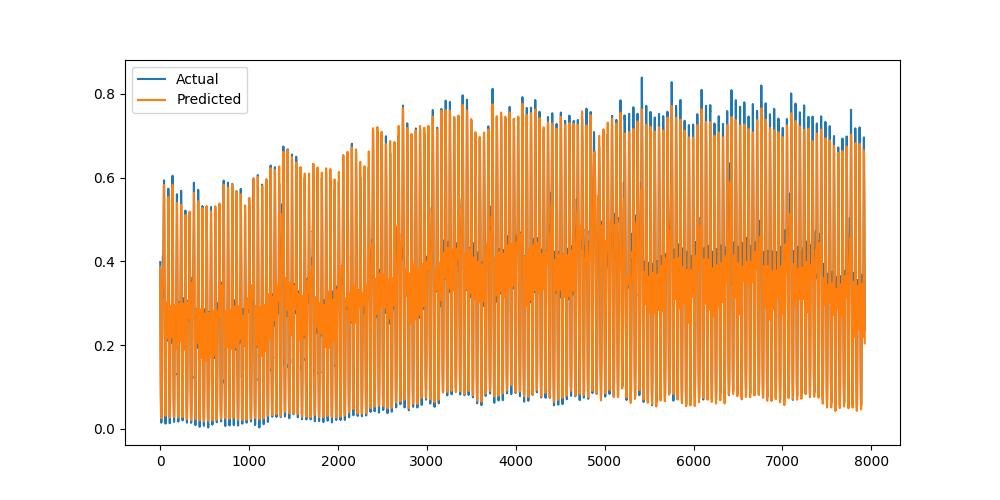

In [66]:
loss = nn.L1Loss()
x_test = dataset_test[:][0]
y_test = dataset_test[:][1]

y_pred = torch.tensor(net_load.predict(x_test))

half_loss = loss(y_pred[:, 0], y_test[:, 0])
hour_loss = loss(y_pred[:, 1], y_test[:, 1])
hour_half_loss = loss(y_pred[:, 2], y_test[:, 2])
hour_20_loss = loss(y_pred[:, 40], y_test[:, 40])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(y_test[:, 0], label='Actual')
ax.plot(y_pred[:, 0], label='Predicted')
#ax.set_title(f'Half Hour Ahead | Loss: {half_loss:.4f}')

#ax[1].plot(y_test[:, 1], label='Actual')
#ax[1].plot(y_pred[:, 1], label='Predicted')
#ax[1].set_title(f'Hour Ahead | Loss: {hour_loss:.4f}')

#ax[2].plot(y_test[:, 2], label='Actual')
#ax[2].plot(y_pred[:, 2], label='Predicted')
#ax[2].set_title(f'Hour and Half Ahead | Loss: {hour_half_loss:.4f}')

#ax[1].plot(y_test[:, 40], label='Actual')
#ax[1].plot(y_pred[:, 40], label='Predicted')
#ax[1].set_xlabel('Time')
#ax[1].set_ylabel('Energy (kWh/hh)')
#ax[1].set_title(f'20 Hours Ahead | Loss: {hour_20_loss:.4f}')

plt.legend()
plt.show()

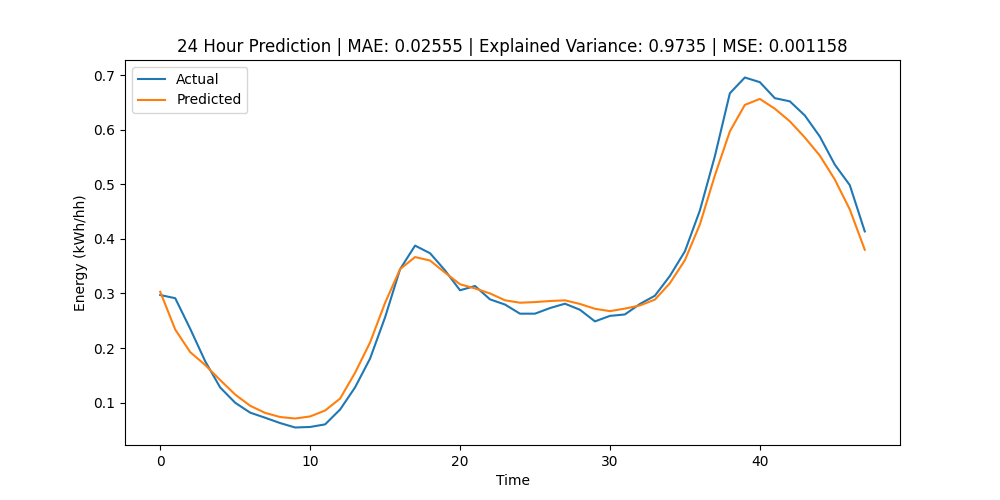

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
y_pred = y_pred.detach().numpy()
y_test = y_test.detach().numpy()
accuracy = mean_absolute_error(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)
mean_squared = mean_squared_error(y_test, y_pred)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(y_test[-3], label='Actual')
ax.plot(y_pred[-3], label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Energy (kWh/hh)')
ax.set_title(f'24 Hour Prediction | MAE: {accuracy:.5f} | Explained Variance: {explained_variance:.4f} | MSE: {mean_squared:.6f}')
plt.legend()

count = np.arange(0, 24, 0.5)
output = np.concatenate((count, y_test[-2], y_pred[-2]), axis=0).reshape(3, 48).T
np.savetxt('../LSTM_results.csv', output, delimiter=',')